## Port of MATLAB PDE solver

Trying to see if I can a Burgers' Equation solver to work in Python for later use with KANs

Referencing this page https://www.mathworks.com/help/deeplearning/ug/solve-partial-differential-equations-with-lbfgs-method-and-deep-learning.html

Importing a few libraries...

In [1]:
import matplotlib.pyplot as plt

import torch.autograd.functional as F
import torch.nn.functional as Fnn
import torch.nn as nn
import torch

First create some basic evaluation points such as boundary conditions

In [2]:
#Establish boundary conditions for x, t, u
numBoundaryConditionPoints = [25, 25]

x0BC1 = -1*torch.ones(1,numBoundaryConditionPoints[0])
x0BC2 = torch.ones(1,numBoundaryConditionPoints[1])

t0BC1 = torch.linspace(0,1,steps=numBoundaryConditionPoints[0]).reshape(1, -1)
t0BC2 = torch.linspace(0,1,steps=numBoundaryConditionPoints[1]).reshape(1, -1)

u0BC1 = torch.zeros(1,numBoundaryConditionPoints[0])
u0BC2 = torch.zeros(1,numBoundaryConditionPoints[1])

#Estabish iniital conditions
numInitialConditionPoints  = 50

x0IC = torch.linspace(-1,1,steps=numInitialConditionPoints).reshape(1, -1)
t0IC = torch.zeros(1,numInitialConditionPoints)
u0IC = -torch.sin(torch.pi*x0IC)

X0 = torch.cat([x0IC, x0BC1, x0BC2],dim=1)
T0 = torch.cat([t0IC, t0BC1, t0BC2],dim=1)
U0 = torch.cat([u0IC, u0BC1, u0BC2],dim=1)

print(X0.shape, T0.shape, U0.shape)

torch.Size([1, 100]) torch.Size([1, 100]) torch.Size([1, 100])


Now create some points for it to evaluate

In [3]:
numInternalCollocationPoints = 10000;

points = torch.randn(numInternalCollocationPoints,2,requires_grad=True)

dataX = 2*points[:,0]-1
dataT = points[:,1]

numBlocks = 8
fcOutputSize = 20

print(points.shape)
print(dataX.shape)
print(dataT.shape)

torch.Size([10000, 2])
torch.Size([10000])
torch.Size([10000])


Now create a neural net for it

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 20)
        self.fc7 = nn.Linear(20, 20)
        self.fc8 = nn.Linear(20, 20)
        self.fc9 = nn.Linear(20, 1)
        self.tanh_n = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh_n(x)
        x = self.fc2(x)
        x = self.tanh_n(x)
        x = self.fc3(x)
        x = self.tanh_n(x)
        x = self.fc4(x)
        x = self.tanh_n(x)
        x = self.fc5(x)
        x = self.tanh_n(x)
        x = self.fc6(x)
        x = self.tanh_n(x)
        x = self.fc7(x)
        x = self.tanh_n(x)
        x = self.fc8(x)
        x = self.tanh_n(x)
        x = self.fc9(x)
        return x

Define loss function (PDE)

In [5]:
def modelLoss(net,X,T,X0,T0,U0):
    #Make predictions with the initial conditions.
    XT = torch.cat([X,T], dim=1)
    U = net.forward(XT)
    
    #Calculate derivatives with respect to X and T.
    X = X.squeeze()
    T = T.squeeze()
    U = U.squeeze()

    #Calculate Jacobian for Ux and Ut
    Ux = torch.autograd.grad(outputs=U, inputs=XT, grad_outputs=torch.ones_like(U), create_graph=True)[0][:,0]
    Ut = torch.autograd.grad(outputs=U, inputs=XT, grad_outputs=torch.ones_like(U), create_graph=True)[0][:,1]
    
    #Calculate second-order derivatives with respect to X (equivalent to trace of Jacobian).
    #Ux.requires_grad=True
    Uxx = torch.autograd.grad(outputs=Ux, inputs=XT, grad_outputs=torch.ones_like(Ux), create_graph=True)[0][:,0]
    
    #Calculate mseF. Enforce Burger's equation.
    f = Ut + torch.mul(Ux,U) - torch.mul(Uxx,(0.01/torch.pi))
    mseF = torch.mean(torch.pow(f,2))
    
    #Calculate mseU. Enforce initial and boundary conditions.
    XT0 = torch.cat([X0,T0],dim=1)
    U0Pred = net.forward(XT0)
    loss_fn = nn.MSELoss()
    mseU = loss_fn(U0Pred,U0)
    
    #Calculated loss to be minimized by combining errors.
    loss = mseF + mseU

    return loss

Train the model

In [11]:
net = Net()

X = dataX.unsqueeze(dim=1)
T = dataT.unsqueeze(dim=1)
X0_ = X0.permute(1, 0)
T0_ = T0.permute(1, 0)
U0_ = U0.permute(1, 0)
epochs = 1500
learn_rate = 0.01

optimizer = torch.optim.LBFGS(net.parameters(), learn_rate)
epoch = 0
def closure():
    optimizer.zero_grad()
    loss = modelLoss(net, X, T, X0_, T0_, U0_)
    loss.backward(retain_graph=True)
        
    return loss

for i in range(epochs):
    optimizer.step(closure)

    if not (epoch % 10):
        loss = closure()
        print(f"Epoch: {epoch}, loss={loss.detach()}")
        
    epoch+=1

Epoch: 0, loss=0.2490597367286682
Epoch: 10, loss=0.18495477735996246
Epoch: 20, loss=0.10093576461076736
Epoch: 30, loss=0.04772551730275154
Epoch: 40, loss=0.039109326899051666
Epoch: 50, loss=0.03481128066778183
Epoch: 60, loss=0.024948645383119583
Epoch: 70, loss=0.015264155343174934
Epoch: 80, loss=0.013263815082609653
Epoch: 90, loss=0.011892047710716724
Epoch: 100, loss=0.01099349558353424
Epoch: 110, loss=0.01056471187621355
Epoch: 120, loss=0.010141221806406975
Epoch: 130, loss=0.00918677169829607
Epoch: 140, loss=0.008610960096120834
Epoch: 150, loss=0.00808919221162796
Epoch: 160, loss=0.007651980500668287
Epoch: 170, loss=0.0072883181273937225
Epoch: 180, loss=0.007125713862478733
Epoch: 190, loss=0.0070282830856740475
Epoch: 200, loss=0.006917125545442104
Epoch: 210, loss=0.006767321843653917
Epoch: 220, loss=0.006570801138877869
Epoch: 230, loss=0.006115211173892021
Epoch: 240, loss=0.005769576411694288
Epoch: 250, loss=0.005621092393994331
Epoch: 260, loss=0.005453310441

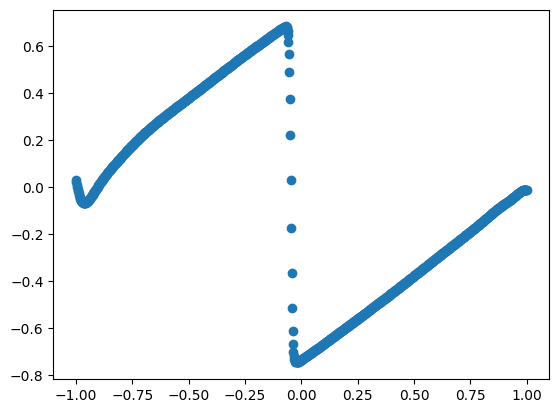

In [22]:
testLen = 1000

TTestVal = 1
TTest = torch.tensor([TTestVal for _ in range(testLen)]).unsqueeze(dim=1)
XTest = torch.linspace(-1, 1, steps=testLen).unsqueeze(dim=1)
XTTest = torch.cat([XTest, TTest], dim=1)

UPredTest = net.forward(XTTest)

plt.scatter(XTest.detach(), UPredTest.detach())